In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import random

import tensorflow as tf

import pickle
import os, sys, time
import shap

In [2]:
def create_data(data_path, normalization = False, scaler = None):
    # read data from file
    dataFrame = pd.read_excel(data_path, sheet_name='Data')

    # Preprocess features: substitute categorial strings with numbers
    string_to_number_set = []
    for col in dataFrame:
        unique_strings = dataFrame.loc[dataFrame[col].apply(lambda x: isinstance(x, str)), col].unique()
        string_to_number = {s: i + 1 for i, s in enumerate(unique_strings)}
        dataFrame[col] = dataFrame[col].replace(string_to_number)
        string_to_number_set.append(string_to_number)
    all_info = dataFrame.iloc[:, 4:32]
    features = all_info.iloc[:, :16]
    targets = all_info.iloc[:, 23:28]
    features_header = features.columns.values
    
    features.columns = features_header

    # Find columns with NaN
    slump_data = pd.concat([features, targets.iloc[:, 0]], axis=1).dropna(axis=0, how='any').values
    comp_str_data = pd.concat([features, targets.iloc[:, 1]], axis=1).dropna(axis=0, how='any').values
    split_str_data = pd.concat([features, targets.iloc[:, 2]], axis=1).dropna(axis=0, how='any').values
    chloride_data = pd.concat([features, targets.iloc[:, 3]], axis=1).dropna(axis=0, how='any').values
    carbon_data = pd.concat([features, targets.iloc[:, 4]], axis=1).dropna(axis=0, how='any').values

    # Put all the information in collections
    X = [
        slump_data[:,:-1],
        comp_str_data[:,:-1],
        split_str_data[:,:-1],
        chloride_data[:,:-1],
        carbon_data[:,:-1],
        
    ]

    Y = [
        slump_data[:, -1:],
        comp_str_data[:, -1:],
        split_str_data[:, -1:],
        chloride_data[:, -1:],
        carbon_data[:, -1:]
    ]

    # Normalization
    if normalization == True:
        if scaler == None:
            scaler = StandardScaler()
        scaler.fit_transform(features)
        X = _normalize_list(X, scaler)

    return X, Y, scaler, features_header

def dataPreparation(X, Y, test_size, random_state, D_contra=True):
    assert len(X) == len(Y)
    T = len(Y)  # number of tasks
    O = [y.shape[1] for y in Y]  # number of outputs for every task
    D = [x.shape[1] for x in X]
    if D_contra == True:
        assert len(list(set(D))) == 1
        D = list(set(D))
        D = D[0] # dimension of feature vector

    X_train = []; Y_train = []; X_test = []; Y_test = []
    for i in range(T):
        x_train, x_test, y_train, y_test = _split_for_single_task(X[i], Y[i], test_size, random_state)
        X_train.append(x_train)
        Y_train.append(y_train)
        X_test.append(x_test)
        Y_test.append(y_test)

    return X_train, Y_train, X_test, Y_test, T, O, D

def _normalize_list(list, scaler):
    normalized_list = []
    for ele in list:
        normed_ele = scaler.transform(ele)
        normalized_list.append(normed_ele)

    return normalized_list

def _split_for_single_task(x, y, test_size, random_state):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    assert x_train.shape[0] == y_train.shape[0] \
           and x_test.shape[0] == y_test.shape[0] \
           and x_train.shape[1] == x_test.shape[1] \
           and y_train.shape[1] == y_test.shape[1]

    return x_train, x_test, y_train, y_test

In [3]:
H1 = 64
H2 = 32
trace_proportion = 0.1
epoch_number = 8000
unify = False
data_dir = 'C:/Users/leeno/Desktop/Dataspell/4102/'
data_name = 'allData.xls'
save_model_path = 'C:/Users/leeno/Desktop/Dataspell/4102/Check'
save_pic_path = 'C:/Users/leeno/Desktop/Dataspell/4102/Check/Pic'
traceNormalizationMethod = 'LAF' # Three methods: 'LAF', 'Tucker', and 'TT'
data_path = os.path.join(data_dir, data_name)
X_all, y_all, scaler, features_header = create_data(data_path, normalization=True)
if unify == False: # Set dimensions of features here!
    X_usage = [pd.DataFrame(X_all[i], columns=features_header) for i in range(len(X_all))]
    y_usage = y_all
    X_usage[0] = X_all[0][:,:-4]
X_train, Y_train, X_test, Y_test, T, O, D = dataPreparation(X_usage, y_usage, test_size=0.2, random_state=42, D_contra=False)

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow.python.framework import function, dtypes


Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
@function.Defun(dtypes.float32, dtypes.float32)
def nuclear_norm_grad(x, dy):
    _, U, V = tf.svd(x, full_matrices=False, compute_uv=True)
    grad = tf.matmul(U, tf.transpose(V))
    return dy * grad


@function.Defun(dtypes.float32, grad_func=nuclear_norm_grad)
def nuclear_norm(x):
    sigma = tf.svd(x, full_matrices=False, compute_uv=False)
    norm = tf.reduce_sum(sigma)
    return norm


def TensorUnfold(A, k):
    tmp_arr = np.arange(A.get_shape().ndims)
    A = tf.transpose(A, [tmp_arr[k]] + np.delete(tmp_arr, k).tolist())
    shapeA = A.get_shape().as_list()
    A = tf.reshape(A, [shapeA[0], np.prod(shapeA[1:])])
    return A


def TensorTraceNorm(X, method='Tucker'):
    shapeX = X.get_shape().as_list()
    dimX = len(shapeX)
    if method == 'Tucker':
        re = [nuclear_norm(i) for i in [TensorUnfold(X, j) for j in range(dimX)]]
    elif method == 'TT':
        re = [nuclear_norm(i) for i in
              [tf.reshape(X, [np.prod(shapeX[:j]), np.prod(shapeX[j:])]) for j in range(1, dimX)]]
    elif method == 'LAF':
        re = [nuclear_norm(TensorUnfold(X, -1))]
    return tf.stack(re)

In [6]:
sess = tf.InteractiveSession()
# a total of 12 variables including 6 weight matrices and 6 bias vectors
# Here we use "TensorTraceNorm" to get the trace norm of shareable layer's parameter (tensor)
########################################################################################################################
# Input to hidden 1
W_input_to_hidden_1 = [tf.Variable(tf.truncated_normal(shape=[d, H1])) for d in D]
b_input_to_hidden_1 = [tf.Variable(tf.zeros(shape=[H1])) for _ in range(T)]

# Hidden 1 to hidden 2
W_input_to_hidden_2 = tf.Variable(tf.truncated_normal(shape=[H1, H2, T]))
Trace_norm_input_to_hidden = TensorTraceNorm(W_input_to_hidden_2, traceNormalizationMethod)
W_input_to_hidden_2 = [W_input_to_hidden_2[:,:,i] for i in range(T)]

# Nothing changes for bias terms or unshared parameters
b_input_to_hidden_2 = [tf.Variable(tf.zeros(shape=[H2])) for _ in range(T)]
W_hidden_to_output = [tf.Variable(tf.truncated_normal(shape=[H2, o])) for o in O]
b_hidden_to_output = [tf.Variable(tf.zeros(shape=[o])) for o in O]

# Build the network as usual
X_placeholder = [tf.placeholder(tf.float32, shape=[None, d]) for d in D]
Y_placeholder = [tf.placeholder(tf.float32, shape=[None, o]) for o in O]
# Add test placeholders
X_test_placeholder = [tf.placeholder(tf.float32, shape=[None, d]) for d in D]
Y_test_placeholder = [tf.placeholder(tf.float32, shape=[None, o]) for o in O]

# Calculate train predictions
Y_hat = [tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(x,w0,b0)),w1,b1)),w2,b2)
         for x,w0,b0,w1,b1,w2,b2 in zip(X_placeholder, W_input_to_hidden_1, b_input_to_hidden_1, W_input_to_hidden_2, \
                                        b_input_to_hidden_2, W_hidden_to_output, b_hidden_to_output)]
# Calculate test predictions
Y_test_hat = [tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(x,w0,b0)),w1,b1)),w2,b2)
              for x,w0,b0,w1,b1,w2,b2 in zip(X_test_placeholder, W_input_to_hidden_1, b_input_to_hidden_1, W_input_to_hidden_2, \
                                             b_input_to_hidden_2, W_hidden_to_output, b_hidden_to_output)]

train_feed_dict = dict(list(zip(X_placeholder, X_train)) + list(zip(Y_placeholder, Y_train)))
test_feed_dict = dict(list(zip(X_test_placeholder, X_test)) + list(zip(Y_test_placeholder, Y_test)))

# Calculate MSE
MSE = [tf.reduce_mean(tf.squared_difference(y, y_hat)) for y, y_hat in zip(Y_placeholder,Y_hat)]
test_MSE = [tf.reduce_mean(tf.squared_difference(y, y_hat)) for y, y_hat in zip(Y_test_placeholder, Y_test_hat)]

# Here we add trace norm as part of losses
loss = tf.reduce_mean(MSE) + trace_proportion * tf.reduce_sum(Trace_norm_input_to_hidden)
test_loss = tf.reduce_mean(test_MSE) + trace_proportion * tf.reduce_sum(Trace_norm_input_to_hidden)

opt = tf.train.AdamOptimizer(learning_rate=0.003)
train = opt.minimize(loss)

# Train the model
init_op = tf.global_variables_initializer() # Workaround: https://github.com/tensorflow/tensorflow/issues/6804
sess.run(init_op)

best_loss = np.inf
best_epoch = 0
saver = tf.train.Saver(max_to_keep=1)
for epoch in range(epoch_number):
    train.run(feed_dict=train_feed_dict)
    train_loss_value = loss.eval(feed_dict=train_feed_dict)
    test_loss_value = test_loss.eval(feed_dict=test_feed_dict)
    if test_loss_value < best_loss:
        if epoch > 5000 and epoch - best_epoch > 10:
            saver.save(sess, save_model_path)
        best_loss = test_loss_value
        best_epoch = epoch
    if epoch % 1000 == 0:
        print("Epoch:", epoch)
        print("Train loss:", train_loss_value)
        print("Test loss:", test_loss_value)
        print("Best loss:", best_loss)

Epoch: 0
Train loss: 24444.438
Test loss: 24682.02
Best loss: 24682.02
Epoch: 1000
Train loss: 18846.883
Test loss: 19023.238
Best loss: 19023.238
Epoch: 2000
Train loss: 15271.735
Test loss: 15429.755
Best loss: 15429.755
Epoch: 3000
Train loss: 12371.323
Test loss: 12514.341
Best loss: 12514.341
Epoch: 4000
Train loss: 9911.468
Test loss: 10039.45
Best loss: 10039.45
Epoch: 5000
Train loss: 7822.71
Test loss: 7936.756
Best loss: 7936.756
Epoch: 6000
Train loss: 6079.032
Test loss: 6179.6924
Best loss: 6179.6924
Epoch: 7000
Train loss: 4587.144
Test loss: 4673.2554
Best loss: 4673.2554


In [7]:
# Start validating
saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, save_model_path)

# Calculate predicted values after training
predicted_values = sess.run(Y_test_hat, feed_dict=test_feed_dict)

# Plot actual vs predicted values with R^2 in the legend
for i in range(T):
    X_plot_values = Y_test[i] 
    Y_plot_values = predicted_values[i] 
    # Calculate R^2 score for each task
    r2 = r2_score(X_plot_values, Y_plot_values)
    # Plot scatters
    plt.scatter(X_plot_values, Y_plot_values, label=f"Task {i + 1} (R^2: {r2:.4f})")
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    # Calculate axis limits
    min_limit = min(X_plot_values.min(), Y_plot_values.min())
    max_limit = max(X_plot_values.max(), Y_plot_values.max())
    # Plot a diagonal
    plt.plot([min_limit, max_limit], [min_limit, max_limit], 'k--', lw=2, label="Diagonal")
    # Set axis limits and equal aspect ratio
    plt.xlim(min_limit, max_limit)
    plt.ylim(min_limit, max_limit)
    plt.gca().set_aspect('equal', adjustable='box')
    # assert X_plot_values.shape == Y_plot_values.shape
    # for j in range(X_plot_values.shape[0]):
    #     print(f"Task {i} Sample {j}: actual:{X_plot_values[j]},predicted:{Y_plot_values[j]}")
    plt.legend()
    # plt.savefig(save_pic_path + 'task_' + str(i) + '.png')
    # plt.savefig(save_pic_path + 'task_' + str(i) + '_R2=' + str(r2) + '.png')
plt.show()

INFO:tensorflow:Restoring parameters from C:/Users/leeno/Desktop/Dataspell/4102/Check


InvalidArgumentError: Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Graph execution error:

Detected at node 'save_1/Assign_39' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    File "C:\Users\leeno\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start
    File "C:\Users\leeno\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
    File "C:\Users\leeno\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever
    File "C:\Users\leeno\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once
    File "C:\Users\leeno\anaconda3\Lib\asyncio\events.py", line 80, in _run
    File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
    File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
    File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
    File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
    File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
    File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
    File "C:\Users\leeno\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
    File "C:\Users\leeno\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
    File "C:\Users\leeno\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    File "C:\Users\leeno\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
    File "C:\Users\leeno\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
    File "C:\Users\leeno\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    File "C:\Users\leeno\AppData\Local\Temp\ipykernel_5372\1137540527.py", line 2, in <module>
Node: 'save_1/Assign_39'
Assign requires shapes of both tensors to match. lhs shape= [32,16] rhs shape= [32,1]
	 [[{{node save_1/Assign_39}}]]

Original stack trace for 'save_1/Assign_39':
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
  File "C:\Users\leeno\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
  File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start
  File "C:\Users\leeno\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
  File "C:\Users\leeno\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever
  File "C:\Users\leeno\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once
  File "C:\Users\leeno\anaconda3\Lib\asyncio\events.py", line 80, in _run
  File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
  File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
  File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
  File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
  File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
  File "C:\Users\leeno\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
  File "C:\Users\leeno\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
  File "C:\Users\leeno\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
  File "C:\Users\leeno\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
  File "C:\Users\leeno\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
  File "C:\Users\leeno\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
  File "C:\Users\leeno\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
  File "C:\Users\leeno\AppData\Local\Temp\ipykernel_5372\1137540527.py", line 2, in <module>
  File "C:\Users\leeno\anaconda3\Lib\site-packages\tensorflow\python\training\saver.py", line 934, in __init__
  File "C:\Users\leeno\anaconda3\Lib\site-packages\tensorflow\python\training\saver.py", line 946, in build
  File "C:\Users\leeno\anaconda3\Lib\site-packages\tensorflow\python\training\saver.py", line 974, in _build
  File "C:\Users\leeno\anaconda3\Lib\site-packages\tensorflow\python\training\saver.py", line 543, in _build_internal
  File "C:\Users\leeno\anaconda3\Lib\site-packages\tensorflow\python\training\saver.py", line 383, in _AddRestoreOps
  File "C:\Users\leeno\anaconda3\Lib\site-packages\tensorflow\python\training\saving\saveable_object_util.py", line 86, in restore
  File "C:\Users\leeno\anaconda3\Lib\site-packages\tensorflow\python\ops\state_ops.py", line 353, in assign
  File "C:\Users\leeno\anaconda3\Lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 61, in assign
  File "C:\Users\leeno\anaconda3\Lib\site-packages\tensorflow\python\framework\op_def_library.py", line 796, in _apply_op_helper
  File "C:\Users\leeno\anaconda3\Lib\site-packages\tensorflow\python\framework\ops.py", line 2652, in _create_op_internal
  File "C:\Users\leeno\anaconda3\Lib\site-packages\tensorflow\python\framework\ops.py", line 1160, in from_node_def


In [61]:
task_num = 0
sample_num = 4
feature_num = 4
x = X_test_placeholder[task_num]
w0 = W_input_to_hidden_1[task_num]
b0 = b_input_to_hidden_1[task_num]
w1 = W_input_to_hidden_2[task_num]
b1 = b_input_to_hidden_2[task_num]
w2 = W_hidden_to_output[task_num]
b2 = b_hidden_to_output[task_num]

def exF(X):
    X = scaler.transform(X)
    test_explain_feed_dict = {X_test_placeholder[task_num]: X}
    Y_test_explain = tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(x,w0,b0)),w1,b1)),w2,b2)
    predicted_values = sess.run(Y_test_explain, feed_dict=test_explain_feed_dict)
    predicted_values = predicted_values.flatten()
    return predicted_values

X_test_task = scaler.inverse_transform(pd.DataFrame(X_test[task_num]))

explainer = shap.KernelExplainer(exF, X_test_task)
shap_values = explainer.shap_values(X_test_task[sample_num], nsamples=500)

ValueError: operands could not be broadcast together with shapes (162,12) (16,) (162,12) 

X does not have valid feature names, but StandardScaler was fitted with feature names
Using 387 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


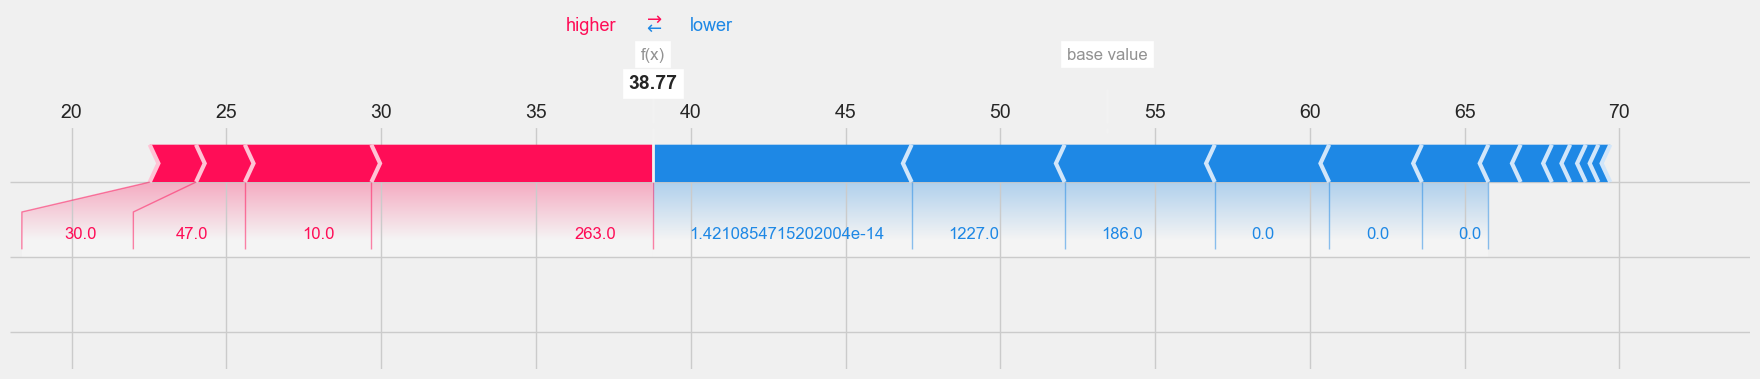

In [8]:

## Force plot (One sample)
shap_values = explainer.shap_values(X_test_task[sample_num], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, X_test_task[sample_num], show=False, matplotlib=True)
plt.show()

In [32]:
explained_sample_df = pd.DataFrame(X_test_task[sample_num])
shap_values_df = pd.DataFrame(shap_values)
features_header_df = pd.DataFrame(features_header)
explain_result = pd.concat([features_header_df, explained_sample_df, shap_values_df], axis=1)

  0%|          | 0/12 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

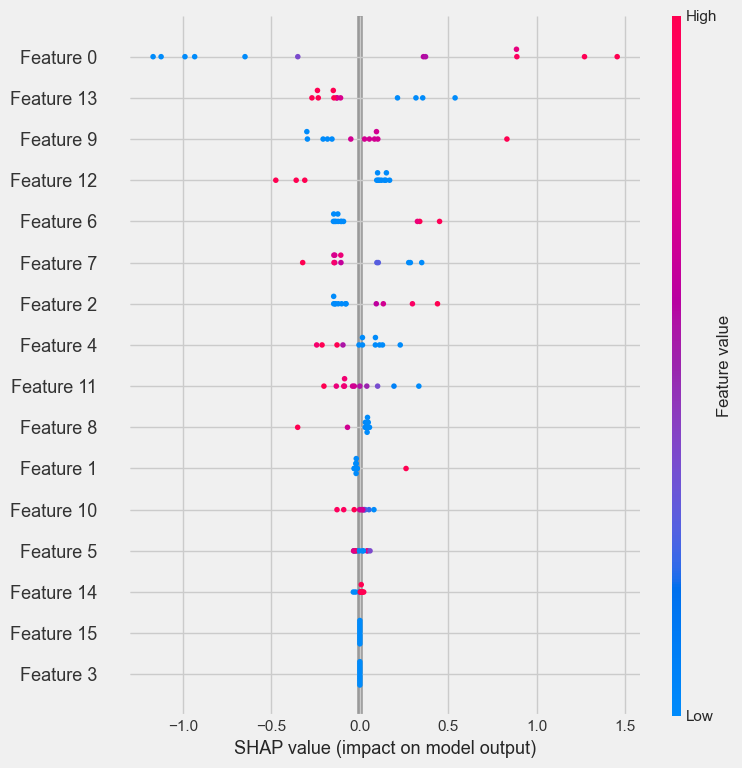

In [33]:
## Summary plot
shap_values = explainer.shap_values(X_test_task)
shap.summary_plot(shap_values, X_test_task)
plt.show()

In [58]:
X_test[1]

,ASTM type 1 ordinary Portland Cement content (kg/m^3),CEM I 42.5N ordinary Portland Cement content (kg/m^3),CEM I 52.5N ordinary Portland Cement content (kg/m^3),Class C Fly ash content (kg/m^3),Class F Fly ash content (kg/m^3),Slag content (kg/m^3),Silica fume content (kg/m^3),Water content (kg/m^3),Superplasticizer content (kg/m^3),Maximum coarse aggregate size (mm),Coarse aggregate content (kg/m^3),Fine aggregate content (kg/m^3),Curing method,Curing temperature (Celsius degree),Curing humidity (%),Curing day
582,-0.368147,-0.652092,0.058470,-0.212624,1.833335,-0.469119,-0.360244,-1.207183,-0.378739,0.229253,0.519100,-0.632421,0.959970,0.506532,0.406536,-0.806361
901,-0.368147,-0.652092,1.329336,-0.212624,-0.540070,-0.469119,1.082095,-0.713608,0.225260,-0.554505,-0.051593,0.583202,-0.993515,-0.530985,0.406536,-1.020258
907,-0.368147,-0.652092,1.397606,-0.212624,-0.540070,-0.469119,-0.360244,-0.361054,-0.494291,-2.122022,0.935673,-0.667523,0.959970,2.927407,-0.000535,0.092004
1753,-0.368147,2.111384,-0.965575,-0.212624,-0.540070,-0.469119,1.774798,3.446526,-0.261495,-0.554505,-1.092672,-0.969396,1.936712,-0.530985,-2.442958,0.092004
1463,-0.368147,0.439652,-0.965575,-0.212624,-0.540070,2.782070,-0.360244,-1.841780,0.775505,-0.554505,0.681441,-0.039205,0.959970,0.160693,0.406536,0.092004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,5.596347,-0.652092,-0.965575,-0.212624,-0.540070,-0.469119,-0.360244,-0.784119,3.399751,-2.122022,-0.424317,-0.723685,-0.993515,1.889889,0.406536,0.092004
1911,1.317267,-0.652092,-0.965575,-0.212624,-0.540070,3.188469,-0.360244,0.273543,0.077118,-1.338263,-0.847016,-0.288426,-0.993515,-0.530985,0.406536,0.092004
1926,3.246130,-0.652092,-0.965575,-0.212624,-0.540070,-0.469119,-0.360244,-1.665503,0.309914,0.229253,0.800900,-0.414792,0.959970,0.506532,0.406536,0.092004
1144,-0.368147,1.394927,-0.965575,-0.212624,-0.540070,-0.469119,-0.360244,1.860034,-0.494291,-1.599516,-2.874749,3.004102,-0.993515,-0.530985,0.406536,0.092004


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

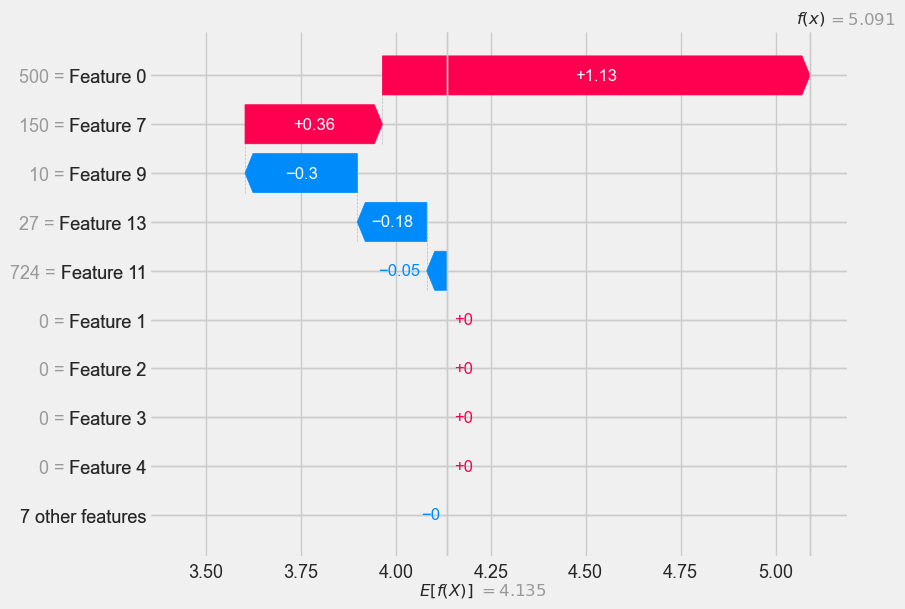

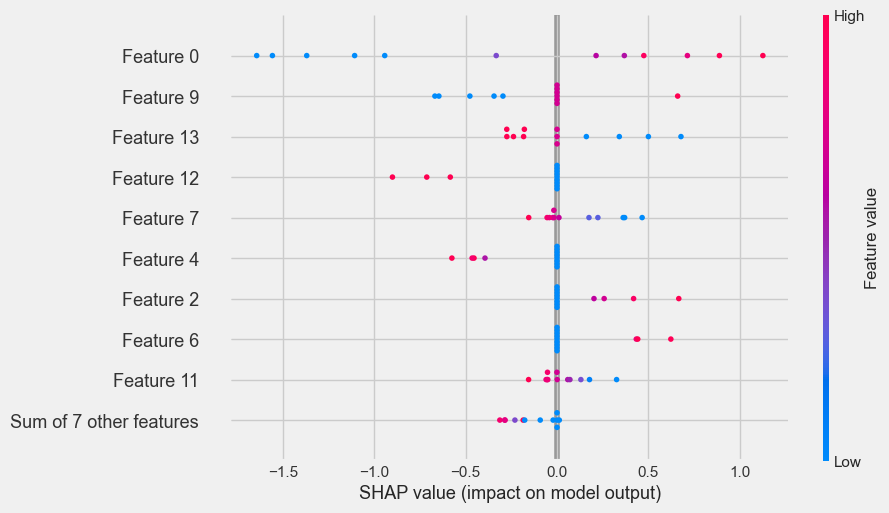

In [34]:
## Waterfall plot, beeswarm plot, heatmap, scatter and histogram plot
X_test_task_df = pd.DataFrame(X_test_task)
med = X_test_task_df.median().values.reshape((1,X_test_task.shape[1]))
explainer = shap.Explainer(exF, med)
shap_values = explainer(X_test_task)
shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values)
#shap.plots.heatmap(shap_values)
#shap.plots.scatter(shap_values)
#shap.plots.scatter(shap_values[:,0])

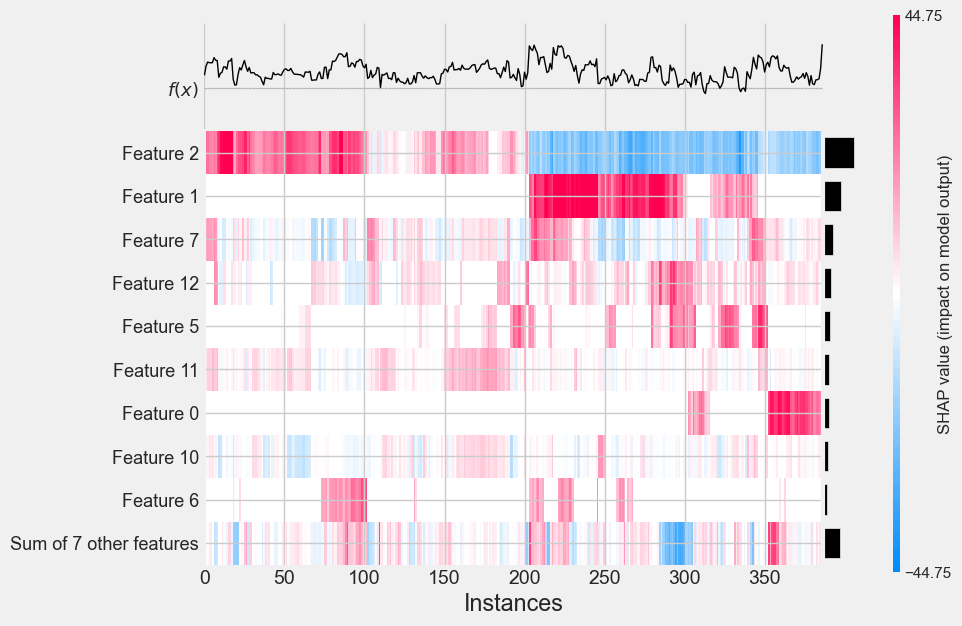

In [10]:
shap.plots.heatmap(shap_values)

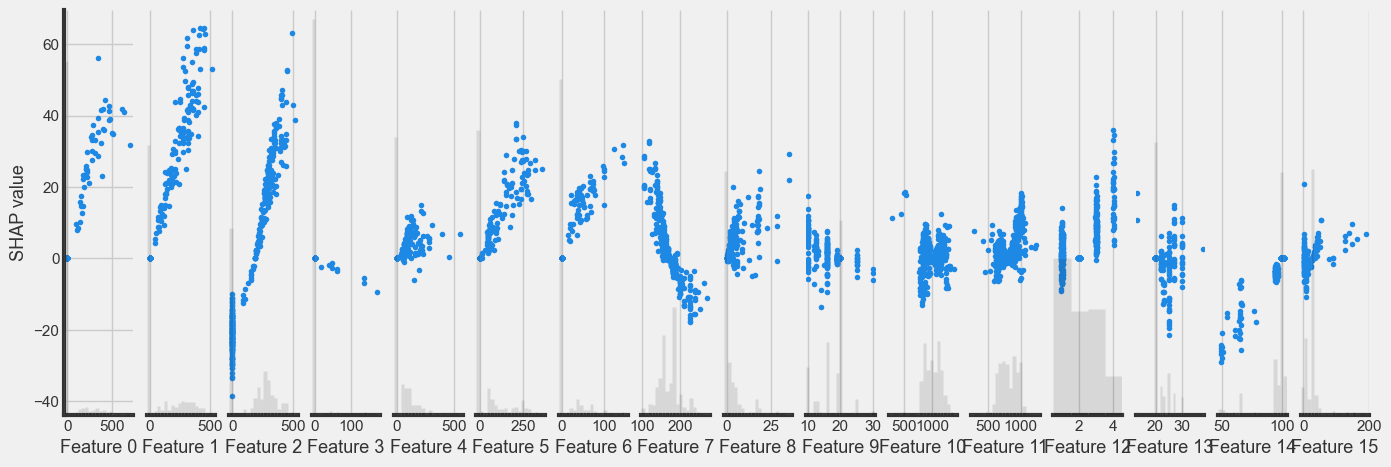

In [11]:
shap.plots.scatter(shap_values)

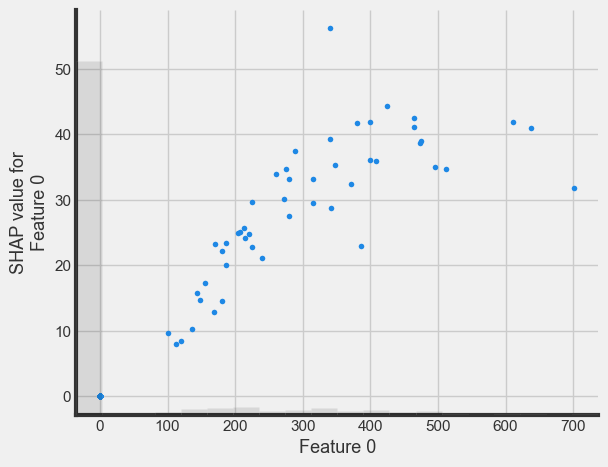

In [12]:
shap.plots.scatter(shap_values[:,0])

In [13]:
X_test_task_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,1.421085e-14,156.0,0.0,156.0,0.0,0.0,138.0,0.546,19.0,1090.000000,724.000000,3.0,23.0,100.0,7.0
1,0.0,1.421085e-14,349.6,0.0,0.0,0.0,30.4,152.0,3.400,16.0,996.842105,897.157895,1.0,20.0,100.0,2.0
2,0.0,1.421085e-14,360.0,0.0,0.0,0.0,0.0,162.0,0.000,10.0,1158.000000,719.000000,3.0,30.0,95.0,28.0
3,0.0,4.050000e+02,0.0,0.0,0.0,0.0,45.0,270.0,1.100,16.0,826.900000,676.000000,4.0,20.0,65.0,28.0
4,0.0,1.600000e+02,0.0,0.0,0.0,240.0,0.0,120.0,6.000,16.0,1116.500000,808.500000,3.0,22.0,100.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,637.0,1.421085e-14,0.0,0.0,0.0,0.0,0.0,150.0,18.400,10.0,936.000000,711.000000,1.0,27.0,100.0,28.0
383,180.0,1.421085e-14,0.0,0.0,0.0,270.0,0.0,180.0,2.700,13.0,867.000000,773.000000,1.0,20.0,100.0,28.0
384,386.0,1.421085e-14,0.0,0.0,0.0,0.0,0.0,125.0,3.800,19.0,1136.000000,755.000000,3.0,23.0,100.0,28.0
385,0.0,3.000000e+02,0.0,0.0,0.0,0.0,0.0,225.0,0.000,12.0,536.000000,1242.000000,1.0,20.0,100.0,28.0


In [15]:
X_test[1]

,ASTM type 1 ordinary Portland Cement content (kg/m^3),CEM I 42.5N ordinary Portland Cement content (kg/m^3),CEM I 52.5N ordinary Portland Cement content (kg/m^3),Class C Fly ash content (kg/m^3),Class F Fly ash content (kg/m^3),Slag content (kg/m^3),Silica fume content (kg/m^3),Water content (kg/m^3),Superplasticizer content (kg/m^3),Maximum coarse aggregate size (mm),Coarse aggregate content (kg/m^3),Fine aggregate content (kg/m^3),Curing method,Curing temperature (Celsius degree),Curing humidity (%),Curing day
582,-0.368147,-0.652092,0.058470,-0.212624,1.833335,-0.469119,-0.360244,-1.207183,-0.378739,0.229253,0.519100,-0.632421,0.959970,0.506532,0.406536,-0.806361
901,-0.368147,-0.652092,1.329336,-0.212624,-0.540070,-0.469119,1.082095,-0.713608,0.225260,-0.554505,-0.051593,0.583202,-0.993515,-0.530985,0.406536,-1.020258
907,-0.368147,-0.652092,1.397606,-0.212624,-0.540070,-0.469119,-0.360244,-0.361054,-0.494291,-2.122022,0.935673,-0.667523,0.959970,2.927407,-0.000535,0.092004
1753,-0.368147,2.111384,-0.965575,-0.212624,-0.540070,-0.469119,1.774798,3.446526,-0.261495,-0.554505,-1.092672,-0.969396,1.936712,-0.530985,-2.442958,0.092004
1463,-0.368147,0.439652,-0.965575,-0.212624,-0.540070,2.782070,-0.360244,-1.841780,0.775505,-0.554505,0.681441,-0.039205,0.959970,0.160693,0.406536,0.092004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,5.596347,-0.652092,-0.965575,-0.212624,-0.540070,-0.469119,-0.360244,-0.784119,3.399751,-2.122022,-0.424317,-0.723685,-0.993515,1.889889,0.406536,0.092004
1911,1.317267,-0.652092,-0.965575,-0.212624,-0.540070,3.188469,-0.360244,0.273543,0.077118,-1.338263,-0.847016,-0.288426,-0.993515,-0.530985,0.406536,0.092004
1926,3.246130,-0.652092,-0.965575,-0.212624,-0.540070,-0.469119,-0.360244,-1.665503,0.309914,0.229253,0.800900,-0.414792,0.959970,0.506532,0.406536,0.092004
1144,-0.368147,1.394927,-0.965575,-0.212624,-0.540070,-0.469119,-0.360244,1.860034,-0.494291,-1.599516,-2.874749,3.004102,-0.993515,-0.530985,0.406536,0.092004
